# RetinaNet with PyTorch

The dataset used can be found at https://www.kaggle.com/datasets/ipythonx/retinal-vessel-segmentation/data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [9]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using {torch.cuda.get_device_name(0)} device")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using {device} device")

Using NVIDIA GeForce GTX 1070 device
Using cuda device


# Load Data

In [10]:
class RetinaDataset(Dataset):
    def __init__(self, imgs, masks, manual, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.manual = manual
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]
        manual = self.manual[idx]

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
            manual = self.transform(manual)

        return img, mask, manual

In [11]:
def read_data(path):
    imgs = []
    masks = []
    manuals = []
    subFolder = os.listdir(path)
    for folder in subFolder:
        if folder == "images":
            for img in os.listdir(os.path.join(path, folder)):
                imgs.append(plt.imread(os.path.join(path, folder, img)))
        elif folder == "mask":
            for mask in os.listdir(os.path.join(path, folder)):
                masks.append(plt.imread(os.path.join(path, folder, mask)))
        elif folder == "manual1" or folder == "1st_manual":
            for manual in os.listdir(os.path.join(path, folder)):
                manuals.append(plt.imread(os.path.join(path, folder, manual)))

    imgs = np.array(imgs)
    masks = np.array(masks)
    manuals = np.array(manuals)
    return imgs, masks, manuals

In [12]:
train_data = read_data("archive/DRIVE/training")
test_data = read_data("archive/DRIVE/test")

In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = RetinaDataset(train_data[0], train_data[1], train_data[2], transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = RetinaDataset(test_data[0], test_data[1], test_data[2], transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Image Visualization

In [14]:
def show_image(img, mask, manual):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    ax[1].axis("off")
    ax[2].imshow(manual)
    ax[2].set_title("Manual")
    ax[2].axis("off")
    plt.show()

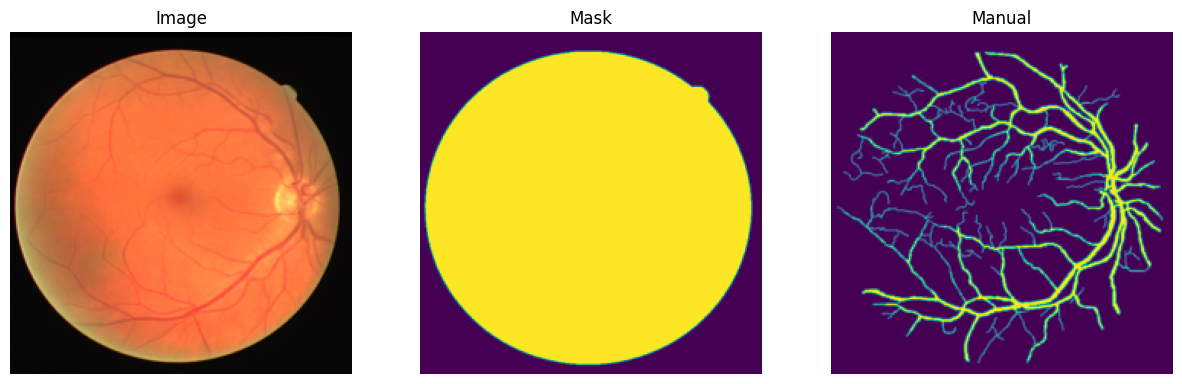

In [15]:
img, mask, manual = train_loader.dataset[0]
show_image(img.permute(1, 2, 0), mask.permute(1, 2, 0), manual.permute(1, 2, 0))

# Model

In [16]:
import torch.nn as nn
from torchvision.models import ResNet50_Weights

In [17]:
class RetinaNet(nn.Module):
    """
    RetinaNet model with ResNet backbone
    """
    def __init__(self, in_channels=3, input_size=(224, 224)):
        super(RetinaNet, self).__init__()
        self.resnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # Remove the fully connected layer
        self.backbone = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Feature Pyramid Network (FPN)
        self.fpn = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.upsample = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False)  # Adjusted to upsample to original size
        
        # Segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)  # For binary segmentation
        )
        
    def forward(self, x):
        # Extract features from the backbone
        features = self.backbone(x)
        
        # Process features through the FPN
        fpn_features = self.fpn(features)

        # Upsample features to nearer input size
        upsampled_features = self.upsample(fpn_features)
        
        # Generate the segmentation map
        segmentation_map = self.segmentation_head(upsampled_features)
        
        # Apply sigmoid activation for binary segmentation
        segmentation_map = torch.sigmoid(segmentation_map)
        
        return segmentation_map

In [18]:
model = RetinaNet()
model = model.to(device)

In [19]:
from loss import DiceLoss

In [20]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [21]:
# Train the model
total_step = len(train_loader)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for image, mask, manual in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        manual = manual.to(device)
        
        # Forward pass
        outputs = model(image)
        loss = criterion(outputs, manual)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/50], Loss: 0.32541775703430176
Epoch [2/50], Loss: 0.2889714539051056
Epoch [3/50], Loss: 0.2820359766483307


Epoch [4/50], Loss: 0.2590324580669403
Epoch [5/50], Loss: 0.2659832537174225
Epoch [6/50], Loss: 0.24698354303836823
Epoch [7/50], Loss: 0.2724795341491699
Epoch [8/50], Loss: 0.25521624088287354
Epoch [9/50], Loss: 0.2432420700788498
Epoch [10/50], Loss: 0.23201575875282288
Epoch [11/50], Loss: 0.24021917581558228
Epoch [12/50], Loss: 0.25411492586135864
Epoch [13/50], Loss: 0.24230660498142242
Epoch [14/50], Loss: 0.2605264484882355
Epoch [15/50], Loss: 0.22265106439590454
Epoch [16/50], Loss: 0.24978524446487427
Epoch [17/50], Loss: 0.241376593708992
Epoch [18/50], Loss: 0.2443229854106903
Epoch [19/50], Loss: 0.24730487167835236
Epoch [20/50], Loss: 0.2378513514995575
Epoch [21/50], Loss: 0.2409949153661728
Epoch [22/50], Loss: 0.23762594163417816
Epoch [23/50], Loss: 0.25231245160102844
Epoch [24/50], Loss: 0.2352168709039688
Epoch [25/50], Loss: 0.25938311219215393
Epoch [26/50], Loss: 0.2173377424478531
Epoch [27/50], Loss: 0.22030457854270935
Epoch [28/50], Loss: 0.22723644971

# Test

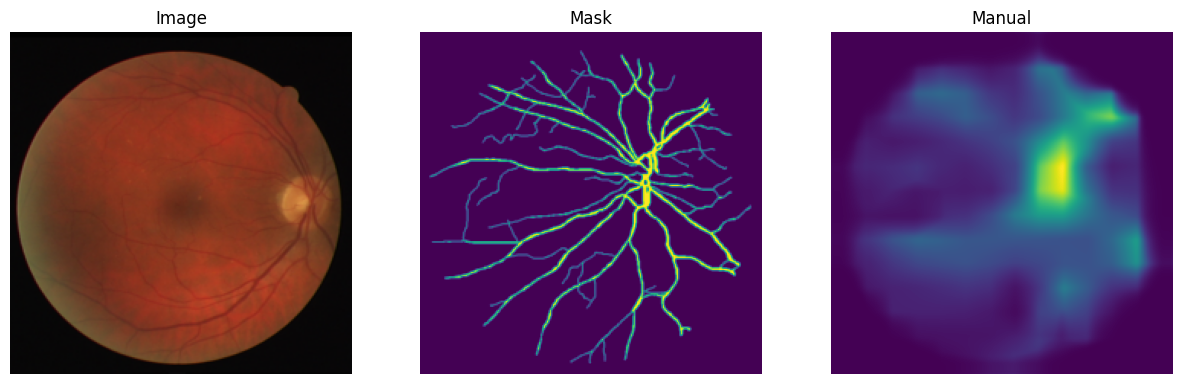

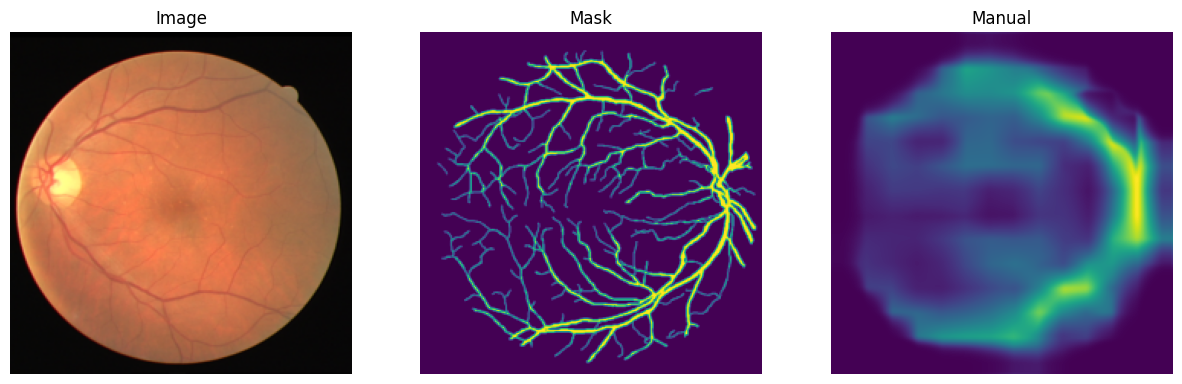

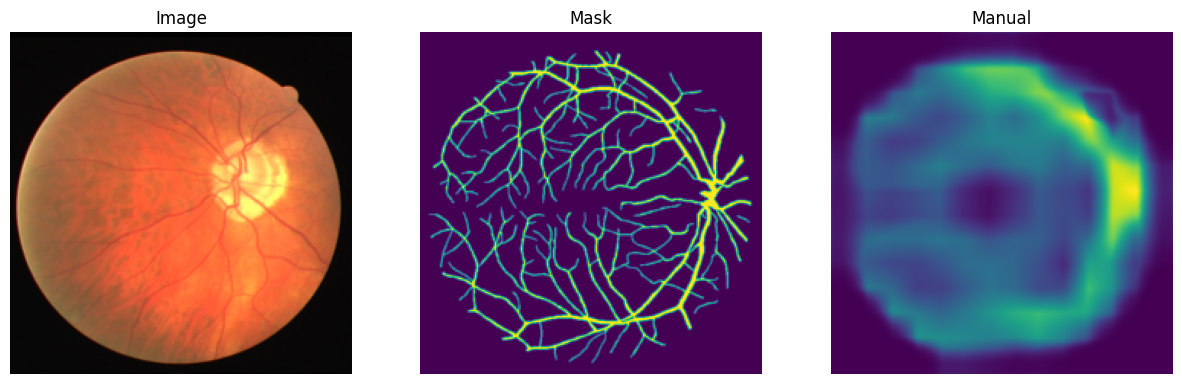

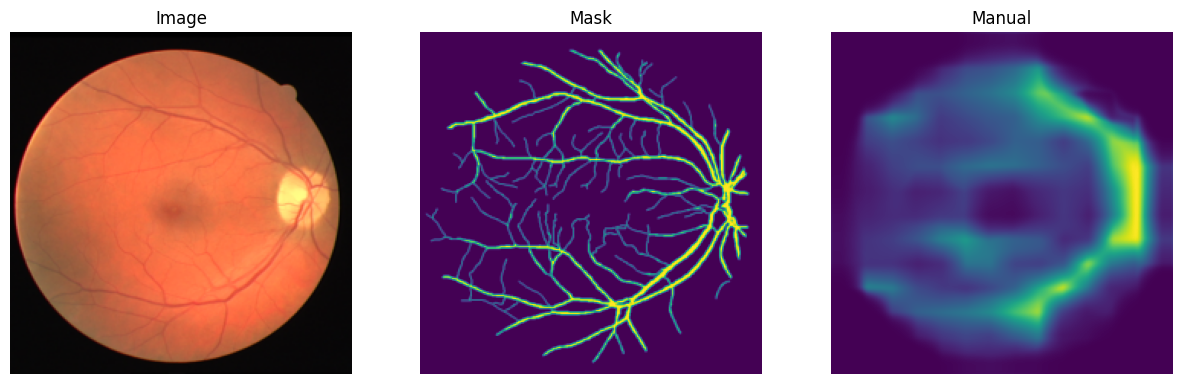

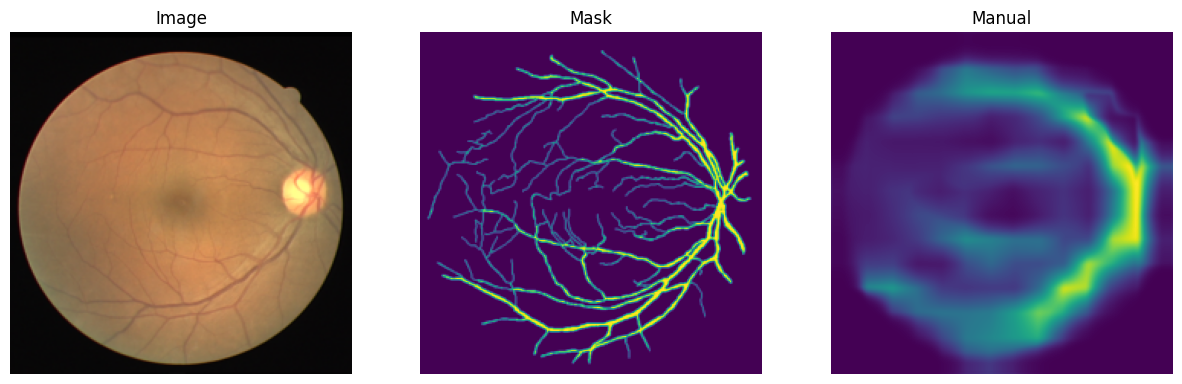

In [22]:
# Predictions for 5 images
model.eval()
with torch.no_grad():
    for i, (image, mask, manual) in enumerate(train_loader):
        image = image.to(device)
        mask = mask.to(device)
        manual = manual.to(device)
        
        # Forward pass
        outputs = model(image)

        # Display the first 5 images
        if i < 5:
            show_image(image[0].cpu().permute(1, 2, 0), manual[0].cpu().permute(1, 2, 0), outputs[0].cpu().permute(1, 2, 0))
        else:
            break